# Analysis de los experimentos de Broadcasting

Autor: Jorge Daniel Laborda

## Introducción
---


En este notebook se analizan los resultados de los experimentos de broadcasting. Hemos experimentado con dos tipos de Broadcasting:
* ALL_BROADCASTING: Al final de cada iteración cogemos todos los BNs generados por los procesos del cges y los fusionamos usando un ConsensusUnion. La red de consenso ahora se pasa a cada proceso de la siguiente iteración de forma que si el proceso obtiene un resultado peor en bdeu a la red de consenso, se sustituye por la red de consenso. El pseudocódigo de este algoritmo sería algo así:
   ```
   Inicio del Algoritmo CGES con All_Broadcasting:
   
   1. Realizar particiones y procesos circulares del algoritmo.
   
   2. Para cada iteración:
      a. Realizar el proceso de CGES en paralelo para generar BNs individuales.
      b. Al final de la iteración:
         - Fusionar todos los BNs generados utilizando ConsensusUnion.
         - Almacenar la red de consenso resultante.
   
      c. Para cada proceso en la siguiente iteración:
         i. Proporcionar la red de consenso como entrada al proceso además de la red del proceso previo.
         ii. Ejecutar el proceso CGES individualmente con la nueva entrada.
         iii. Comparar el resultado en términos de BDeu con la red de consenso.
         iv. Si el resultado del proceso es peor, reemplazar la red del proceso con la red de consenso.
   
   3. Repetir el ciclo hasta que se cumpla el criterio de convergencia.
   
   Fin del Algoritmo CGES con All_Broadcasting.
   ```

----------------------------------------------------------

* PAIR_BORADCASTING: Este cambio es un poco distinto al previo ya que toca directamente la fusión de cada proceso. En este caso, todas las redes generadas en cada iteración se comparten con las demás redes, para la siguiente iteración. Por lo tanto, en la fase de fusión del proceso circular están disponibles todas las redes generadas por los demás procesos. Ahora, la red construida por el proceso se fusiona con las demás redes a pares. Por ejemplo, si tenemos 4 procesos (A,B,C y D). En el proceso A están disponibles las redes de B, C y D. Las fusiones realizadas serían A con B, A con C y A con D. Se calcularía la puntuación bdeu de cada red generada, y el proceso se quedaría con la red con la mejor bdeu. Para refinar el proceso, aplicamos un BES al final. Después el proceso circular continua aplicando a esta red nueva un GES con los enlaces a los que está limitado y se repite hasta que haya una convergencia. 
El pseudocódigo quedaría algo así:
   ```
   Inicio del Algoritmo CGES con Pair Broadcasting:
   
   1. Realizar particiones y procesos circulares del algoritmo.
   
   2. Para cada iteración:
      a. Realizar el proceso de CGES en paralelo para generar BNs individuales.
      b. Al final de la iteración:
         - Compartir todas las redes generadas con los demás procesos.
         - Para cada proceso:
            i. Fusionar la red construida por el proceso con las demás redes a pares.
            ii. Calcular la puntuación BDeu de cada red resultante.
            iii. Seleccionar la red con la mejor puntuación BDeu y actualizar la red del proceso.
   
      c. Aplicar un BES a la red seleccionada por cada proceso.

      d.  Aplicar un GES a la red resultante, limitado a los enlaces permitidos.

      e.  Actualizar la red del proceso con el resultado del GES.
   
   3. Repetir el ciclo hasta que se cumpla el criterio de convergencia.
   
   Fin del Algoritmo CGES con Pair Broadcasting.
```



### Descripción de los Experimentos realizados
Los experimentos han utilizado los siguientes parámetros: algName,netName,clusteringName,numberOfRealThreads,convergence,broadcasting. 
Los valores de los parámetros son los siguientes:
* algName: CGES
* netName: Nombre de la red a utilizar. En este caso, se han usado las redes andes, link, pigs y munin.
* clusteringName: Nombre del clustering a utilizar. En este caso solo se ha usado el HierarchicalClustering.
* numberOfRealThreads: Número de hilos a utilizar. El número de particiones de enlace se elige con este valor. En este caso, se han usado 1,2,4 y 8 hilos.
* convergence: Criterio de convergencia. En este caso, se ha usado el criterio `c2` que comprueba si algún BN de la iteración actual es mejor a la mejor BN obtenida hasta el momento.
* broadcasting: Tipo de broadcasting a utilizar. En este caso, se han usado los tipos `ALL_BROADCASTING` y `PAIR_BROADCASTING`.

Los experimentos se han lanzado sobre un nodo cluster2 del supercomputador galgo (`select=1:ncpus=16:mem=32gb:cluster=galgo2`).

A continuación realizaremos el análisis de los resultados obtenidos.

# Preprocesamiento

In [22]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
pd.read_csv('results_best_broadcasting.csv')

,algName,netName,clusteringName,numberOfRealThreads,convergence,broadcasting,database,elapsedTime(s),shd,dfMM_avg,dfMM_plus,dfMM_minus,iterations,bdeu
0,cges,andes,HierarchicalClustering,1,c2,BEST_BROADCASTING,andes00,11.180,149.0,322.0,0.0,0.0,4.0,-4.720728e+05
1,cges,andes,HierarchicalClustering,1,c2,BEST_BROADCASTING,andes01,11.371,150.0,326.0,0.0,0.0,4.0,-4.720113e+05
2,cges,andes,HierarchicalClustering,1,c2,BEST_BROADCASTING,andes02,11.992,136.0,294.0,0.0,0.0,5.0,-4.718370e+05
3,cges,andes,HierarchicalClustering,1,c2,BEST_BROADCASTING,andes03,11.411,156.0,336.0,10.0,10.0,4.0,-4.708994e+05
4,cges,andes,HierarchicalClustering,1,c2,BEST_BROADCASTING,andes04,11.392,150.0,322.0,10.0,10.0,4.0,-4.709608e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,cges,pigs,HierarchicalClustering,8,c2,BEST_BROADCASTING,pigs07,31.275,8.0,24.0,24.0,24.0,17.0,-1.675845e+06
169,cges,pigs,HierarchicalClustering,8,c2,BEST_BROADCASTING,pigs08,33.925,9.0,30.0,30.0,30.0,18.0,-1.678049e+06
170,cges,pigs,HierarchicalClustering,8,c2,BEST_BROADCASTING,pigs09,31.912,4.0,16.0,16.0,16.0,16.0,-1.675496e+06
171,cges,pigs,HierarchicalClustering,8,c2,BEST_BROADCASTING,pigs10,33.315,4.0,16.0,16.0,16.0,18.0,-1.675409e+06


In [24]:
df_random = pd.read_csv('results_random.csv')
df_random.head()

,algName,netName,clusteringName,numberOfRealThreads,convergence,broadcasting,seed,database,elapsedTime(s),shd,dfMM_avg,dfMM_plus,dfMM_minus,iterations,bdeu
0,cges,pigs,HierarchicalClustering,1,c2,RANDOM_BROADCASTING,2,pigs00,74.090,0.0,0.0,0.0,0.0,4.0,-1.673767e+06
1,cges,pigs,HierarchicalClustering,2,c2,RANDOM_BROADCASTING,31,pigs08,38.452,0.0,0.0,0.0,0.0,7.0,-1.677057e+06
2,cges,pigs,HierarchicalClustering,2,c2,RANDOM_BROADCASTING,37,pigs08,52.131,8.0,30.0,30.0,30.0,14.0,-1.677823e+06
3,cges,pigs,HierarchicalClustering,2,c2,RANDOM_BROADCASTING,41,pigs08,43.421,0.0,0.0,0.0,0.0,11.0,-1.677084e+06
4,cges,pigs,HierarchicalClustering,2,c2,RANDOM_BROADCASTING,43,pigs08,99.436,59.0,178.0,172.0,172.0,6.0,-1.683610e+06


In [26]:
def read_random_data():
    df_random = pd.read_csv("results_random.csv")
    df_random = df_random.drop(columns=['seed'], axis=1)
    return df_random

def read_data():
    df_broadcasting = pd.read_csv("results_broadcasting.csv")
    df_best_broadcasting = pd.read_csv("results_best_broadcasting.csv")
    df_random = read_random_data()
    return pd.concat([df_broadcasting, df_best_broadcasting, df_random])
df = read_data()
df.head()

,algName,netName,clusteringName,numberOfRealThreads,convergence,broadcasting,database,elapsedTime(s),shd,dfMM_avg,dfMM_plus,dfMM_minus,iterations,bdeu
0,cges,andes,HierarchicalClustering,1,c2,ALL_BROADCASTING,andes00,11.863,149.0,322.0,0.0,0.0,4.0,-472072.842349
1,cges,andes,HierarchicalClustering,1,c2,ALL_BROADCASTING,andes01,11.811,150.0,326.0,0.0,0.0,4.0,-472011.273898
2,cges,andes,HierarchicalClustering,1,c2,ALL_BROADCASTING,andes02,12.012,136.0,294.0,0.0,0.0,5.0,-471837.045290
3,cges,andes,HierarchicalClustering,1,c2,ALL_BROADCASTING,andes03,11.72,156.0,336.0,10.0,10.0,4.0,-470899.402586
4,cges,andes,HierarchicalClustering,1,c2,ALL_BROADCASTING,andes04,11.752,150.0,322.0,10.0,10.0,4.0,-470960.838856


## Experimentos Fallidos o Incompletos

In [27]:
import pandas as pd
import itertools

def find_missing_experiments(df):
    # Define los valores posibles para cada parámetro
    netNames = df.netName.unique()
    databases = [f'{network}{i:02d}' for i in range(11) for network in netNames]
    broadcasting_types = ['ALL_BROADCASTING', 'PAIR_BROADCASTING', 'NO_BROADCASTING', 'BEST_BROADCASTING', 'RANDOM_BROADCASTING']
    thread_values = [1, 2, 4, 8]

    # Crea todas las combinaciones posibles de parámetros
    all_combinations = list(itertools.product(databases, broadcasting_types, thread_values))

    # Convierte las combinaciones en un DataFrame para buscarlas en el DataFrame original
    all_combinations_df = pd.DataFrame(all_combinations, columns=['database', 'broadcasting', 'threads'])

    # Busca las combinaciones en el DataFrame original
    missing_experiments = pd.merge(all_combinations_df, df, on=['database', 'broadcasting', 'threads'], how='left')

    # filas con un NaN en cualquier columna
    failed_experiments = df[df.isnull().any(axis=1)]

    # Filtra las filas donde faltan experimentos o hay errores (valores nulos)
    missing_or_failed_experiments = missing_experiments[missing_experiments.isnull().any(axis=1)]

    # Imprime los resultados
    if not missing_or_failed_experiments.empty or not failed_experiments.empty:
        print("Experimentos faltantes:")
        print(missing_or_failed_experiments[['database', 'broadcasting', 'threads']])
        print("Number of missing experiments:", len(missing_or_failed_experiments))
        print("-----------------------------------")
        print("Experimentos con errores:")
        print(failed_experiments[['database', 'broadcasting', 'threads']])
        print("Number of failed experiments:", len(failed_experiments))
    else:
        print("Todos los experimentos han sido ejecutados correctamente.")


# Read csv
df = read_data()
# Dropping unnneccesary columns
df = df.drop(['algName','clusteringName', 'convergence'], axis=1)

# Rename columns
df = df.rename(columns={'elapsedTime(s)': 'time', 'numberOfRealThreads' : 'threads'})
find_missing_experiments(df)


Experimentos faltantes:
     database         broadcasting  threads
273   munin00     ALL_BROADCASTING        2
274   munin00     ALL_BROADCASTING        4
275   munin00     ALL_BROADCASTING        8
278   munin00    PAIR_BROADCASTING        4
279   munin00    PAIR_BROADCASTING        8
...       ...                  ...      ...
4834  munin10    BEST_BROADCASTING        8
4835  munin10  RANDOM_BROADCASTING        1
4836  munin10  RANDOM_BROADCASTING        2
4837  munin10  RANDOM_BROADCASTING        4
4838  munin10  RANDOM_BROADCASTING        8

[218 rows x 3 columns]
Number of missing experiments: 218
-----------------------------------
Experimentos con errores:
     database         broadcasting  threads
244    link05    PAIR_BROADCASTING        4
281    link08    PAIR_BROADCASTING        8
319   munin05     ALL_BROADCASTING        2
322   munin09     ALL_BROADCASTING        2
339   munin01     ALL_BROADCASTING        4
...       ...                  ...      ...
3951  munin02  RAND

In [29]:
# Read data from all files of results
df = read_data()

# array of strings of parameters: algName, netName, database, clusteringName, numberOfRealThreads, convergence, broadcasting
param_columns = ["algName", "netName", "database", "clusteringName", "numberOfRealThreads", "convergence", "broadcasting"]
#array of measurments:
measurement_columns = ["time", "shd", "dfMM_avg", "dfMM_plus", "dfMM_minus", "iterations", "bdeu"]

# Dropping unnneccesary columns
df = df.drop(['algName','clusteringName', 'convergence'], axis=1)

# Rename elapsedTime to time
df = df.rename(columns={'elapsedTime(s)': 'time', 'numberOfRealThreads' : 'threads'})

# Drop all rows with NaN values
df = df.dropna()

# Transform to numeric values all measurement columns
df[measurement_columns] = df[measurement_columns].apply(pd.to_numeric)


# Create a new df with the _all databases
df_all =df.copy()
df_all = df[df.database.str.contains("_ALL")]

# Drop databases with _all in the name of the database
df = df[~df.database.str.contains("_ALL")]
df.drop(['database'], axis=1, inplace=True)

df.shape


(4757, 10)

In [30]:
df_all.shape

(403, 11)

# Análisis Descriptivo

In [31]:
# Estadísticas descriptivas
desc_stats = df.groupby(['netName', 'threads', 'broadcasting'])['shd'].describe()

# Visualizar
print(desc_stats)

                                     count        mean        std    min  \
netName threads broadcasting                                               
andes   1       ALL_BROADCASTING      11.0  150.636364   8.464901  136.0   
                BEST_BROADCASTING     11.0  150.636364   8.464901  136.0   
                NO_BROADCASTING       11.0  150.636364   8.464901  136.0   
                PAIR_BROADCASTING     11.0  150.636364   8.464901  136.0   
                RANDOM_BROADCASTING  330.0  150.636364   8.083223  136.0   
...                                    ...         ...        ...    ...   
pigs    8       ALL_BROADCASTING      10.0   24.700000  15.048440    5.0   
                BEST_BROADCASTING     11.0    6.000000   3.949684    1.0   
                NO_BROADCASTING       11.0    6.363636   5.220589    0.0   
                PAIR_BROADCASTING     11.0    9.454545   4.251203    1.0   
                RANDOM_BROADCASTING  330.0    2.781818   3.223343    0.0   

           

# Visualización

In [32]:
def plot_barplot(df,network, x, y, hue):
    # Select the data for the specified network
    df_visualization = df.loc[df["netName"] == network].dropna()

    # Configure Seaborn
    sns.set(style="whitegrid")

    # Plot the barplot
    plt.figure(figsize=(12, 8))
    sns.barplot(x=x, y=y, hue=hue, data=df_visualization)
    plt.title(f'Distribution of {y} by {x} and {hue} for {network} network')
    plt.show()

def plot_lineplot(df,network,x,y,hue):
     # Select the data for the specified network
    df_visualization = df.loc[df["netName"] == network].dropna()
    #df_visualization = df_visualization.groupby(['threads', 'broadcasting']).mean().reset_index()
    df_visualization = df_visualization.reset_index(drop=True)
    # Configure Seaborn
    sns.set(style="whitegrid")

    # Plot the barplot
    plt.figure(figsize=(12, 8))
    sns.lineplot(x=x, y=y, hue=hue, data=df_visualization)
    plt.title(f'Distribution of {y} by {x} and {hue} for {network} network')
    plt.show()

In [33]:
# df_plot es el dataframe donde threads != 1
df_plot = df[df.threads != 1]
network_plot='andes'

--------------------------------------------------
Network: link
Metric: time


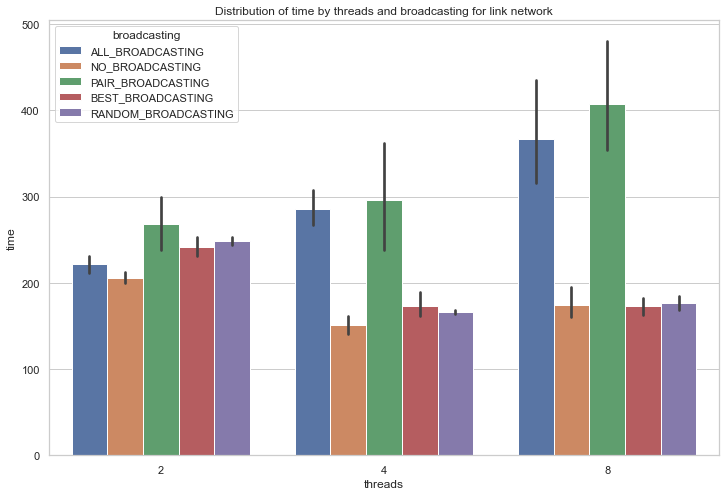

Metric: shd


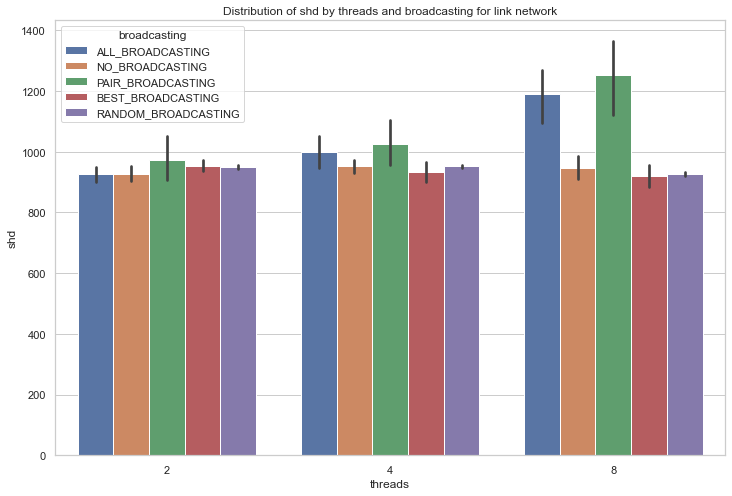

Metric: bdeu


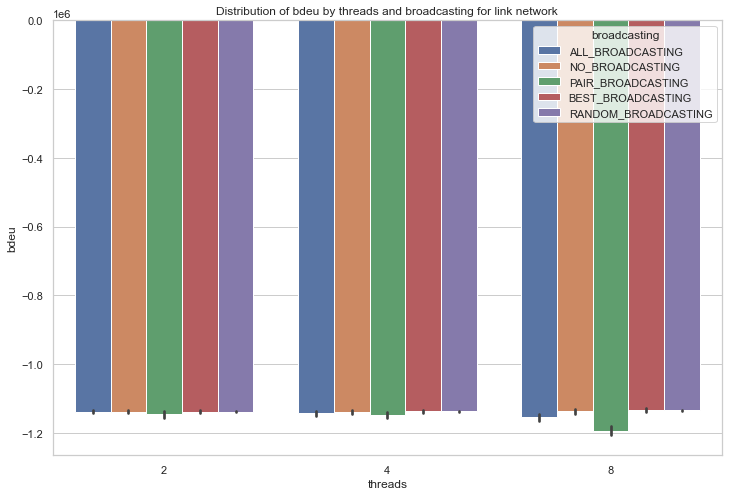

In [34]:
for network in ["link"]:#df_plot.netName.unique():
    print("--------------------------------------------------")
    print("Network: " + network)
    for metric in ['time', 'shd', 'bdeu']:
        print("Metric: " + metric)
        plot_barplot(df=df_plot,network=network, x='threads', y=metric, hue='broadcasting')


--------------------------------------------------
Network: andes
Metric: time


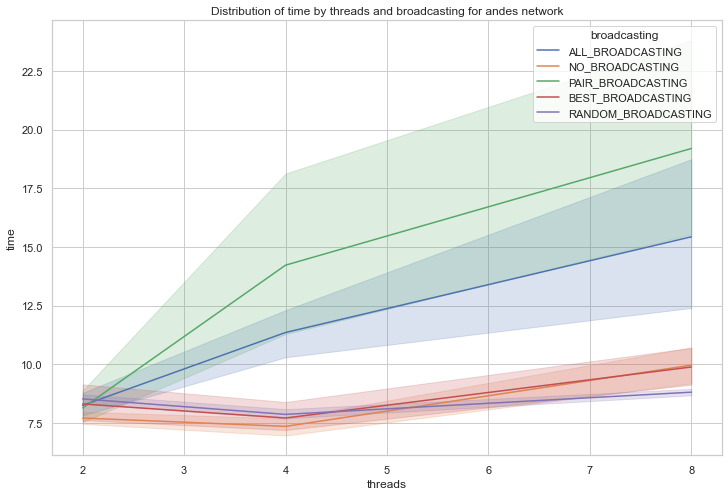

Metric: shd


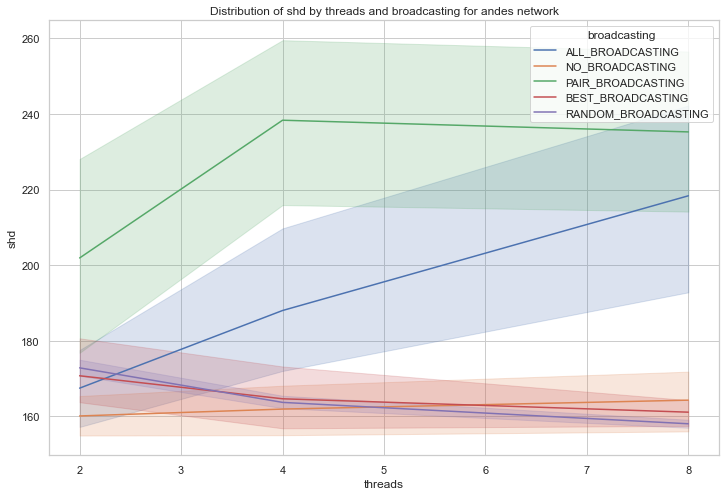

Metric: bdeu


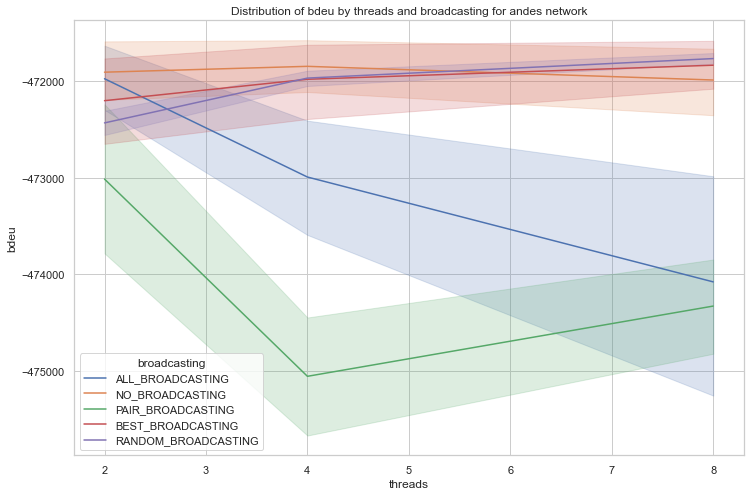

--------------------------------------------------
Network: link
Metric: time


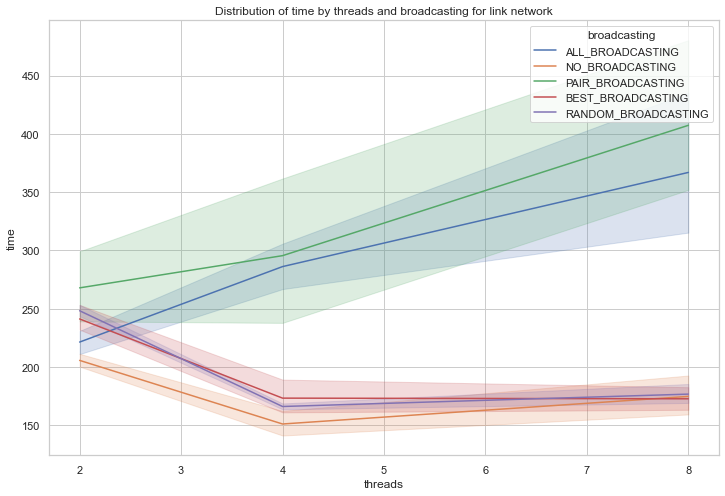

Metric: shd


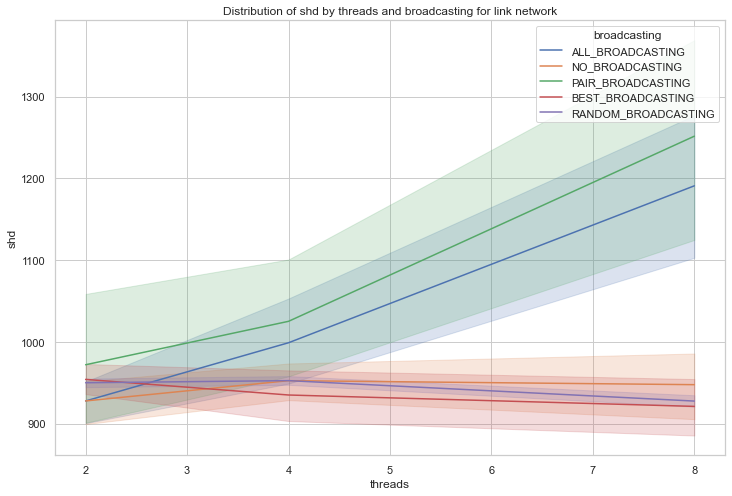

Metric: bdeu


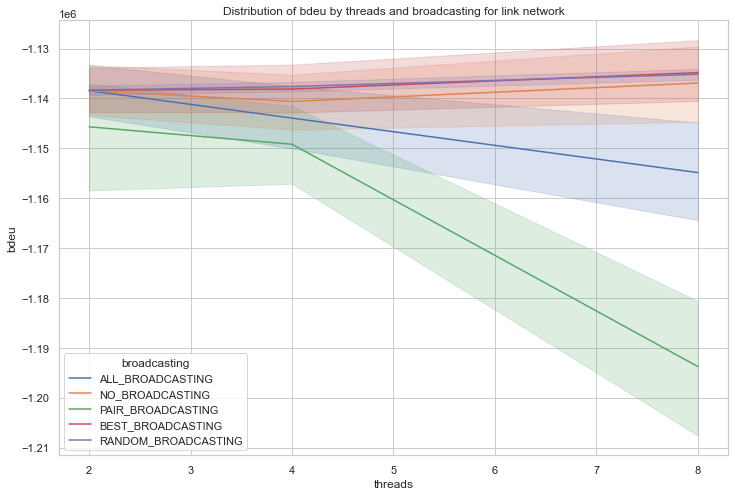

--------------------------------------------------
Network: pigs
Metric: time


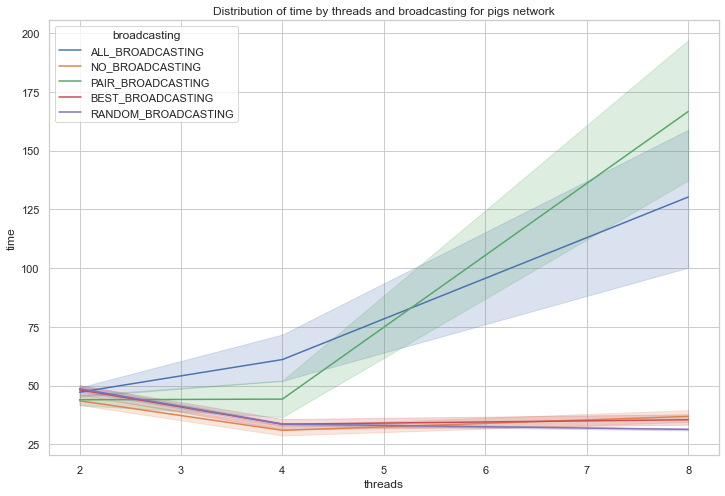

Metric: shd


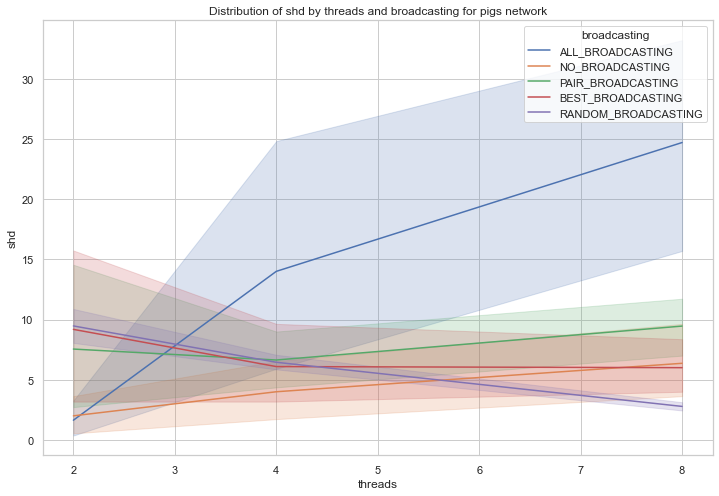

Metric: bdeu


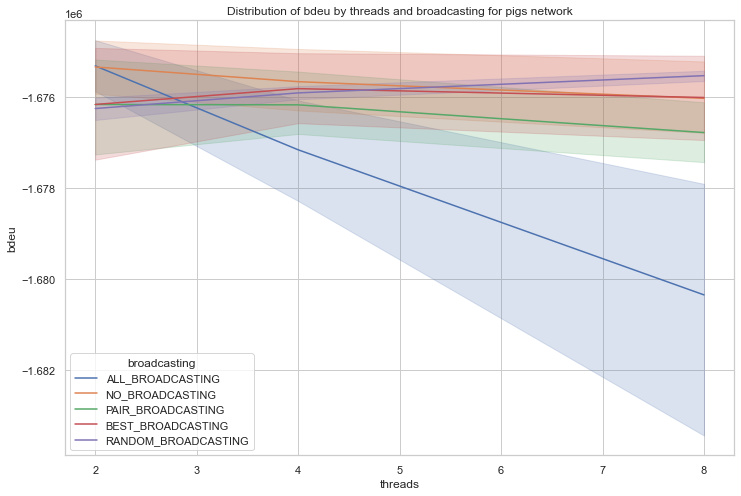

In [37]:
for network in df_plot.netName.unique():
    if network == 'munin':
        continue
    print("--------------------------------------------------")
    print("Network: " + network)
    for metric in ['time', 'shd', 'bdeu']:
        print("Metric: " + metric)
        plot_lineplot(df=df_plot,network=network, x='threads', y=metric, hue='broadcasting')

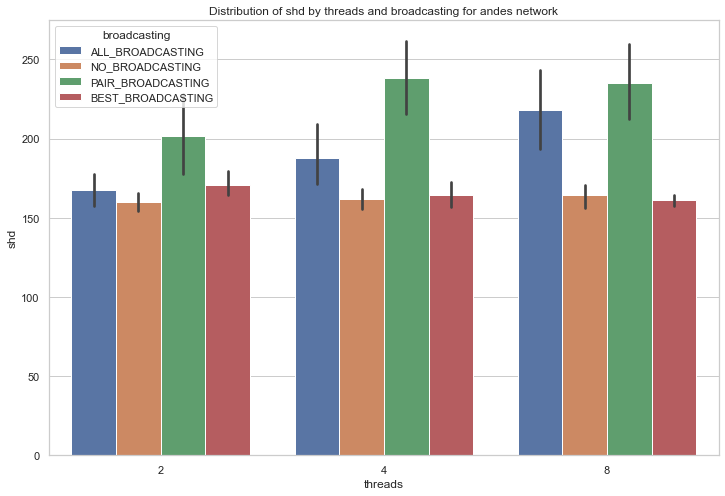

In [12]:
plot_barplot(df=df_plot,network=network_plot,x="threads", y="shd",hue="broadcasting")

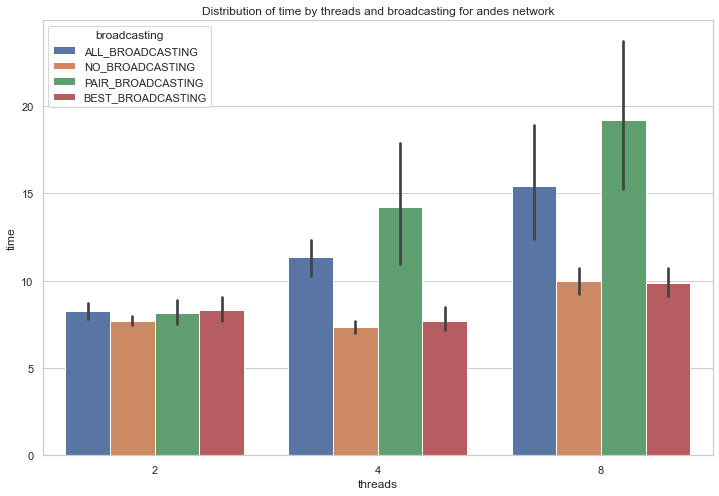

In [13]:
plot_barplot(df=df_plot,network=network_plot,x="threads", y="time",hue="broadcasting")

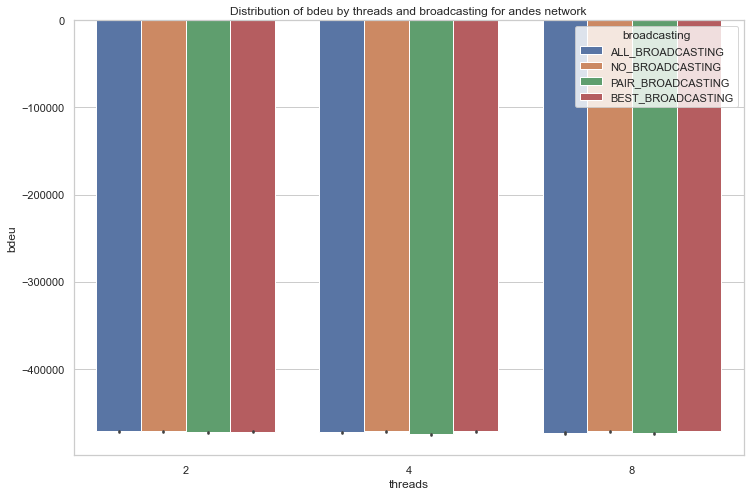

In [14]:
plot_barplot(df=df_plot,network=network_plot,x="threads", y="bdeu",hue="broadcasting")

El análisis de los resultados concluye que el broadcasting no mejora los resultados del algoritmo CGES. Por lo tanto, no se recomienda su uso.

# Tests Estadísticos

In [15]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Supongamos que df tiene las columnas 'config', 'Metrica1', 'Metrica2', ...
# donde 'config' es la variable categórica que representa cada configuración.

def compare_configurations(df):
    metrics = ['bdeu', 'shd', 'time']

    df["config"] = "cges-" + df['threads'].astype(str) + '-' + df['broadcasting']


    for metric in metrics:
        anova_result = f_oneway(*[df[df['config'] == config][metric] for config in df['config'].unique()])
        print(f"ANOVA para {metric}:")
        print(anova_result)
        print()

    for metric in metrics:
        tukey_result = pairwise_tukeyhsd(df[metric], df['config'])
        print(f"Prueba de Tukey para {metric}:")
        print(tukey_result)
        print()

# compare_configurations(df)

In [16]:
compare_configurations(df)

ANOVA para bdeu:
F_onewayResult(statistic=0.04985671252706793, pvalue=0.9999999654840304)

ANOVA para shd:
F_onewayResult(statistic=1.4443676279639341, pvalue=0.12133043790823225)

ANOVA para time:
F_onewayResult(statistic=6.424539715903894, pvalue=9.12987718107409e-13)

Prueba de Tukey para bdeu:
                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
         group1                   group2            meandiff  p-adj    lower        upper    reject
---------------------------------------------------------------------------------------------------
 cges-1-ALL_BROADCASTING cges-1-BEST_BROADCASTING         0.0   1.0 -344696.5257 344696.5257  False
 cges-1-ALL_BROADCASTING   cges-1-NO_BROADCASTING    -21.4471   1.0 -344717.9727 344675.0786  False
 cges-1-ALL_BROADCASTING cges-1-PAIR_BROADCASTING         0.0   1.0 -344696.5257 344696.5257  False
 cges-1-ALL_BROADCASTING  cges-2-ALL_BROADCASTING -19282.0285   1.0 -377326.5526 338762.4956  False
 

In [17]:
# Análisis de Convergencia
from scipy.stats import ttest_ind

# Comparación de dos configuraciones específicas (por ejemplo, ALL_BROADCASTING vs. PAIR_BROADCASTING)


config_1 = df[(df['broadcasting'] == 'ALL_BROADCASTING') & (df['threads'] == 1)]['bdeu']
config_2 = df[(df['broadcasting'] == 'PAIR_BROADCASTING') & (df['threads'] == 1)]['bdeu']

# Prueba t de muestras independientes
t_stat, p_value = ttest_ind(config_1, config_2)

# Visualizar resultados
print(f'Test t: {t_stat}, p-value: {p_value}')


Test t: 0.0, p-value: 1.0


## Exreport

In [38]:
import os
import shutil
# Crear una copia de df llamada df_exreport
df = df[df.threads != 1]

# Eliminamos el network munin para el exreport
df = df[df.netName != 'munin']

df_exreport = df.copy()

# Crear una columna con las configuraciones separadas por espacio. Los valores de las configuraciones están en las columnas threads y broadcasting
df_exreport['config'] = "cges" #+ df_exreport['threads'].astype(str) + '-' + df_exreport['broadcasting']

# Eliminar las columnas threads y broadcasting
#df_exreport = df_exreport.drop(['broadcasting'], axis=1)

df_exreport = df_exreport.groupby(["netName","config", "broadcasting", "threads"],observed=True).mean().reset_index()

# Redondear a 4
df_exreport = df_exreport.round(4)

# Write to csv ./exreport/exreport.csv
df_exreport.to_csv('./exreport/exreport.csv', index=False)

# Delete folder exreport_output and its content if exists
if os.path.exists('./exreport/exreport_output'):
    shutil.rmtree('./exreport/exreport_output')

# Execute exreport.r
os.system('Rscript ./exreport/exreport.r')


256

In [19]:
def generate_score_table(score_col):
    # Obtener las columnas de parámetros
    param_columns = ["algName", "netName", "clusteringName", "threads", "convergence", "broadcasting"]

    # Obtener las columnas del score
    columns = [col for col in df.columns if col.startswith(score_col)]

    # Obtener las columnas a eliminar
    columns_to_drop = [col for col in df.columns if col not in param_columns and col not in columns]

    # Eliminar las columnas
    df_unstack = df.drop(columns_to_drop, axis=1)

    # Añadir columna config
    df_unstack['config'] = "cges-" + df_unstack['threads'].astype(str) + '-' + df_unstack['broadcasting']

    # Eliminar las columnas threads y broadcasting
    df_unstack = df_unstack.drop(["threads", "broadcasting"], axis=1)

    table = df_unstack.groupby(["netName", "config"], observed=True).mean().unstack(0)
    table = table.transpose()

    # Changue index to network
    table.index = table.index.droplevel(0)

    # Ordering table
    table = table.reindex(['munin','pigs','link','andes'])

    # Capitalize the first letter of the network
    table.index = table.index.str.capitalize()

    return table

In [20]:
generate_score_table("shd")

config,cges-2-ALL_BROADCASTING,cges-2-BEST_BROADCASTING,cges-2-NO_BROADCASTING,cges-2-PAIR_BROADCASTING,cges-4-ALL_BROADCASTING,cges-4-BEST_BROADCASTING,cges-4-NO_BROADCASTING,cges-4-PAIR_BROADCASTING,cges-8-ALL_BROADCASTING,cges-8-BEST_BROADCASTING,cges-8-NO_BROADCASTING,cges-8-PAIR_BROADCASTING
netName,,,,,,,,,,,,
Munin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pigs,1.636364,9.181818,2.000000,7.545455,14.000000,6.090909,4.000000,6.636364,24.700000,6.000000,6.363636,9.454545
Link,927.727273,954.090909,927.727273,972.000000,998.909091,935.000000,952.545455,1025.111111,1190.818182,921.090909,947.636364,1251.500000
Andes,167.454545,170.727273,160.090909,201.909091,188.000000,164.636364,161.909091,238.363636,218.363636,161.090909,164.272727,235.272727
